[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/makhmudlp/Quran_Audio_Classification_CNN/blob/main/Audio_Classification_Quran.ipynb
)


# Quran Audio Classification using CNN and Spectrograms

This notebook implements a CNN-based audio classification pipeline
using Mel-spectrogram representations of Quran recitation audio.




## Dataset Download

In [8]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in "./quran-recitations-for-audio-classification" (use force=True to force download)


## Libraries and Environment Setup


In [9]:
# the libraries we need
import torch
from torch import nn
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

# changing device from cpu to gpu if gpu is available
device='cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

## Data Exploration and Preprocessing


Datashape:  (6687, 2)


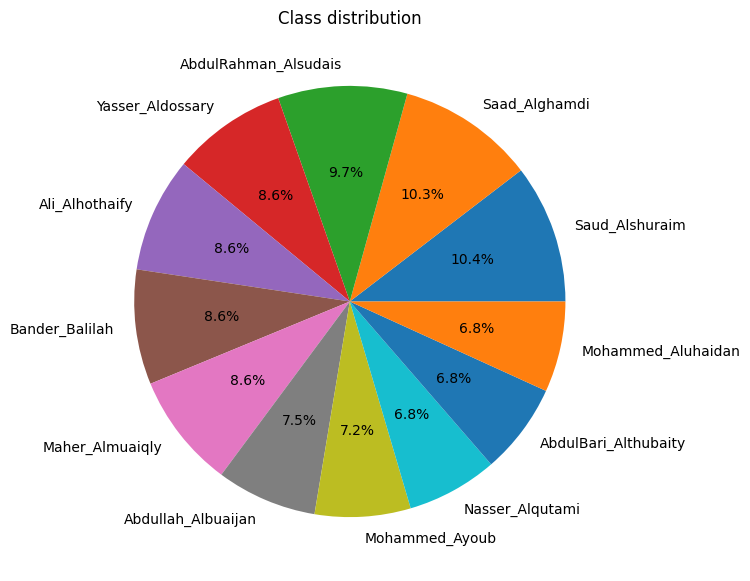

In [10]:
#Visualizing to check our data equally distrubuted
data_df=pd.read_csv('quran-recitations-for-audio-classification/files_paths.csv')
data_df["FilePath"]="/content/quran-recitations-for-audio-classification/Dataset"+data_df["FilePath"].str[1:]

print("Datashape: ", data_df.shape)
plt.figure(figsize=(10,7))
plt.pie(data_df['Class'].value_counts(), labels=data_df['Class'].value_counts().index, autopct="%1.1f%%")
plt.title("Class distribution")
plt.show()


## Train / Validation / Test Split


In [11]:
label_encoder=LabelEncoder()
data_df["Class"]=label_encoder.fit_transform(data_df['Class'])

train=data_df.sample(frac=0.7, random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5, random_state=7)
test=test.drop(val.index)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)
print("Val shape: ", val.shape)

Train shape:  (4681, 2)
Test shape:  (1003, 2)
Val shape:  (1003, 2)


## Custom Dataset and Spectrogram Generation


In [12]:
class CustomAudioDataset(Dataset):
  def __init__(self,dataframe):
    self.dataframe=dataframe
    self.labels=torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios=[torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, index):
    img_path=self.dataframe.iloc[index,0]
    label=torch.Tensor(self.labels[index]).to(device)
    audio= self.audios[index].unsqueeze(dim=0).to(device)
    return audio,label
  def get_spectogram(self,file_path):
    sr=22050
    duration=5

    img_height=128
    img_width=256

    signal, sr=librosa.load(file_path, sr=sr, duration=duration)

    spectrogram=librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    spectrogram=librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram=librosa.util.fix_length(spectrogram, size=(duration*sr)//512+1)
    spectrogram=resize(spectrogram, (img_height, img_width), anti_aliasing=True)
    return spectrogram


In [13]:
train_dataset=CustomAudioDataset(train)
test_dataset=CustomAudioDataset(test)
val_dataset=CustomAudioDataset(val)

In [14]:
LR=1e-4
BATCH_SIZE=16
EPOCHS=7


In [15]:
train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
len(data_df['Class'].unique())

12

## CNN Model Architecture


### CNN Architecture
The model consists of three convolutional layers with ReLU activations and max pooling,
followed by fully connected layers with dropout for regularization.
Spectrograms are treated as single-channel images.

In [32]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3, padding=1)
    self.conv2=nn.Conv2d(16,32,kernel_size=3, padding=1)
    self.conv3=nn.Conv2d(32,64,kernel_size=3, padding=1)
    self.pooling=nn.MaxPool2d(2,2)
    self.relu=nn.ReLU()

    self.flatten=nn.Flatten()
    self.linear1=nn.LazyLinear(4096) # I used LazyLiner just not to get shape error after Flattening LazyLinear automatically calculates the in_features
    self.linear2=nn.Linear(4096, 2048)
    self.linear3=nn.Linear(2048, 512)
    self.output=nn.Linear(512, len(data_df['Class'].unique()))

    self.dropout=nn.Dropout(0.5)
  def forward(self, x):
    x=self.conv1(x)
    x=self.pooling(x)
    x=self.conv2(x)
    x=self.pooling(x)
    x=self.conv3(x)
    x=self.pooling(x)
    x=self.relu(x)
    #print(x.shape)
    #x=x.view(x.size(0), -1)
    #print(x.shape)
    x=self.flatten(x)
    #print(x.shape)
    x=self.linear1(x)
    x=self.dropout(x)

    x=self.linear2(x)
    x=self.dropout(x)

    x=self.linear3(x)
    x=self.dropout(x)

    x=self.output(x)
    return x


In [33]:
model=Net().to(device)


In [34]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

## Training and Validation

In [35]:
print(len(train_dataloader), len(train_dataset))
print(next(iter(train_dataloader))[0].shape)

293 4681
torch.Size([16, 1, 128, 256])


In [36]:
from prompt_toolkit import output
total_loss_train_plot=[]
total_loss_val_plot=[]
total_acc_train_plot=[]
total_acc_val_plot=[]
start_time=time.time()
from tqdm import tqdm
for epoch in tqdm(range(EPOCHS)):
  model.train()
  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0

  for input, labels in train_dataloader:
    output=model(input)
    loss=loss_fn(output, labels)
    total_loss_train+=loss.item()

    optimizer.zero_grad()
    loss.backward()

    train_acc=(torch.argmax(output, axis=1)==labels).sum().item()
    total_acc_train+=train_acc

    optimizer.step()
  model.eval()
  with torch.no_grad():
    for input, labels in val_dataloader:
      output=model(input)
      loss=loss_fn(output, labels)
      total_loss_val+=loss.item()

      val_acc=(torch.argmax(output, axis=1)==labels).sum().item()
      total_acc_val+=val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 3))
  total_loss_val_plot.append(round(total_loss_val/1000, 3))


  total_acc_train_plot.append(round(total_acc_train/len(train_dataset), 3))
  total_acc_val_plot.append(round(total_acc_val/len(val_dataset), 3))

  print(f"Epoch: {epoch}/{EPOCHS}")
  print(f"Train Loss: {total_loss_train/1000:.2f}, Train Accuracy: {(total_acc_train/len(train_dataset)):.2f}")
  print(f"Val Loss: {total_loss_val/1000:.2f}, Val Accuracy: {(total_acc_val/len(val_dataset)):.2f}")
  print("<>"*30)
training_time=time.time()-start_time
print(f"Training time: {training_time:.2f} seconds")

 14%|█▍        | 1/7 [00:18<01:50, 18.41s/it]

Epoch: 0/7
Train Loss: 0.79, Train Accuracy: 0.48
Val Loss: 0.04, Val Accuracy: 0.80
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


 29%|██▊       | 2/7 [00:36<01:31, 18.35s/it]

Epoch: 1/7
Train Loss: 0.14, Train Accuracy: 0.85
Val Loss: 0.02, Val Accuracy: 0.91
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


 43%|████▎     | 3/7 [00:55<01:13, 18.44s/it]

Epoch: 2/7
Train Loss: 0.09, Train Accuracy: 0.91
Val Loss: 0.02, Val Accuracy: 0.93
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


 57%|█████▋    | 4/7 [01:13<00:55, 18.54s/it]

Epoch: 3/7
Train Loss: 0.06, Train Accuracy: 0.93
Val Loss: 0.01, Val Accuracy: 0.96
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


 71%|███████▏  | 5/7 [01:33<00:37, 18.98s/it]

Epoch: 4/7
Train Loss: 0.05, Train Accuracy: 0.94
Val Loss: 0.01, Val Accuracy: 0.95
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


 86%|████████▌ | 6/7 [01:53<00:19, 19.21s/it]

Epoch: 5/7
Train Loss: 0.06, Train Accuracy: 0.94
Val Loss: 0.02, Val Accuracy: 0.93
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>


100%|██████████| 7/7 [02:12<00:00, 18.91s/it]

Epoch: 6/7
Train Loss: 0.05, Train Accuracy: 0.95
Val Loss: 0.01, Val Accuracy: 0.95
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Training time: 132.34


In [37]:
total_acc_train_plot[4]

0.943

## Evaluation and Results


In [38]:
with torch.no_grad():
  model.eval()
  total_loss_test=0
  total_acc_test=0
  for input, labels in test_dataloader:
    output=model(input)

    acc=(torch.argmax(output, axis=1)==labels).sum().item()
    total_acc_test+=acc
print(f"Test accuracy: {total_acc_test/len(test_dataset):.2f}")


Test accuracy: 0.95


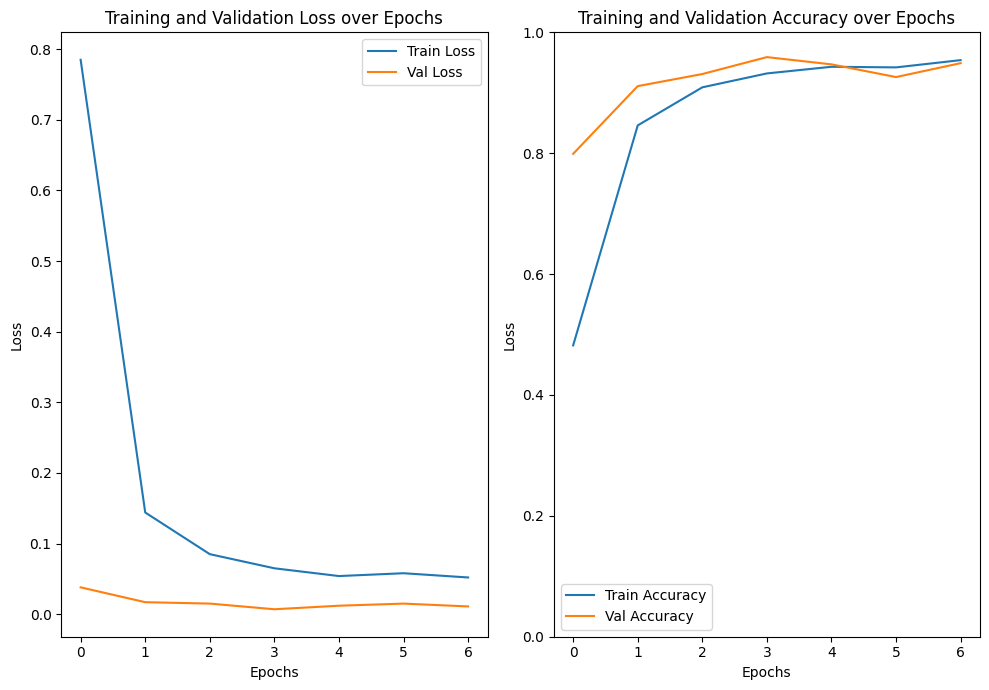

In [39]:
fig, axs =plt.subplots(nrows=1, ncols=2, figsize=(10,7))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Val Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Accuracy")
axs[1].plot(total_acc_val_plot, label="Val Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_ylim([0,1])
axs[1].legend()

plt.tight_layout()
plt.show()